In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
import os
import glob
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm
from scipy import interpolate
import itertools

from utils_analysis import *
from PIL import Image, ImageFilter  

In [2]:
import cv2

In [3]:
def adjust_gamma(img_bgr):
    gamma22LUT = np.array([pow(x/255.0 , 2.2) for x in range(256)],
                           dtype='float32')
    #img_bgr = cv2.imread(infile)
    img_bgrL = cv2.LUT(img_bgr, gamma22LUT)
    img_grayL = cv2.cvtColor(img_bgrL, cv2.COLOR_BGR2GRAY)
    img_gray = pow(img_grayL, 1.0/2.2) * 255
    return img_gray

In [4]:
plt.rcParams["font.family"] = "Arial" 
#plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

In [5]:
dataset_dir = "../dataset/Costela_Woods_2019/preprocessed_data"

In [6]:
mds_dist = np.load("../results/mds_dist_N2010_dim32.npz", allow_pickle=True)

In [7]:
mds_dist_dict = mds_dist["mds_dist"].item()
mds_dist_min_dict = mds_dist["mds_dist_min"].item()

In [8]:
training_methods = ["dino", "supervised"] 
depth_list = [4, 8, 12]
num_models = 6

In [9]:
best_head_indices_dict = {}
num_top = 5
for tm in training_methods:
    best_head_indices_dict[tm] = {}
    for depth in depth_list:
        model_mds_dist = mds_dist_dict[tm][str(depth)]
        num_models = len(model_mds_dist)
        best_head_indices = np.zeros((num_models, num_top, 3))
        for i in range(num_models):
            model_mds_dist_min = np.sort(model_mds_dist[i].flatten())[:num_top]
            for j in range(num_top):
                model_indices = np.argwhere(model_mds_dist == model_mds_dist_min[j])
                best_head_indices[i, j] = model_indices[0]
        best_head_indices_dict[tm][str(depth)] = best_head_indices

In [10]:
video_names = ["MISSP_9a", "Cloud_13a", "MARCH_6b"]#["ADVEN_12a", "Cloud_13a", "DEEPB_11a"]#_c" #  160 # DEEPB_9a_c/0020.png
frame_indices = [50, 260, 511]#[160, 261, 40]
num_videos = len(video_names)

In [11]:
tm = training_methods[0]
depth = depth_list[-1]
best_head_idx = best_head_indices_dict[tm][str(depth)]
patch_size = 16
sigma = patch_size/6

In [12]:
bh_vit_gaze_pos_list = []
gaze_data_list = []
for video_name, frame_idx in zip(video_names, frame_indices):
    # vision transformer
    vit_pos_path = f"{dataset_dir}/vit_gaze_pos/{video_name}_c.npz"
    vit_gaze_pos = np.load(vit_pos_path, allow_pickle=True)
    vit_gaze_pos_part = vit_gaze_pos[tm].item()[str(depth)][:, :, :, frame_idx]

    bh_vit_gaze_pos = np.zeros((num_models, num_top, 2))
    for i in range(num_models):
        for j in range(num_top):
            idx = best_head_idx[i, j].astype(int)
            bh_vit_gaze_pos[i, j] = vit_gaze_pos_part[idx[0], idx[1], idx[2]]
    bh_vit_gaze_pos_noise = bh_vit_gaze_pos + np.random.randn(num_models, num_top, 2) * sigma
    bh_vit_gaze_pos_f = bh_vit_gaze_pos_noise.reshape(-1, 2)
    bh_vit_gaze_pos_list .append(bh_vit_gaze_pos_f)

    # participants
    gaze_data = np.load(f"{dataset_dir}/subj_gaze_pos_upsampled/{video_name}.npz")
    
    subj_names = gaze_data.files
    gaze_pos = []
    for subj in subj_names:
        # gaze posisions at begin, middle and end of frame
        gaze_pos.append(gaze_data[subj][:, frame_idx*30+1])
        gaze_pos.append(gaze_data[subj][:, int(frame_idx*30.5)])
        gaze_pos.append(gaze_data[subj][:, int(frame_idx*31)])
        #gaze_pos.append(gaze_data[subj][:, frame_idx*30:frame_idx*31].T)
    #gaze_pos = np.array(gaze_pos).reshape(-1, 2)
    gaze_pos = np.array(gaze_pos)
    gaze_data_list.append(gaze_pos)

In [13]:
fps = 29.93

In [14]:
genres = ['drama/other', 'cartoon/animation', 'doc/nature']

In [15]:
cmap = sns.color_palette("colorblind")
#cmap = sns.color_palette("bright")

In [16]:
[len(x) for x in gaze_data_list]

[39, 36, 33]

In [17]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [18]:
i = 0
video_name = video_names[i]
frame_idx = frame_indices[i]
f"{dataset_dir}/clips_png_original/{video_name}_c/{frame_idx:04d}.png"

'../dataset/Costela_Woods_2019/preprocessed_data/clips_png_original/MISSP_9a_c/0050.png'

(362, 853, 3)
(480, 853, 3)
(480, 853, 3)


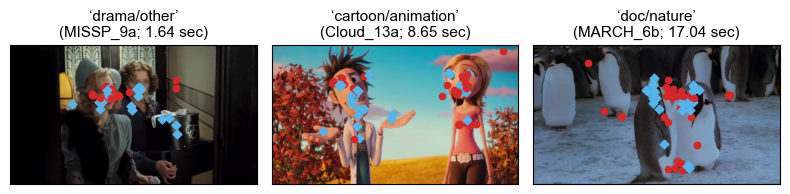

In [23]:
fig, axes = plt.subplots(1, num_videos, figsize=(8,3))
for i in range(num_videos):
    video_name = video_names[i]
    frame_idx = frame_indices[i]
    if i == 0:
        img = cv2.imread(f"../figures/masked_frames/{video_name}_c_{frame_idx:04d}.png")
    else:
        img = cv2.imread(f"{dataset_dir}/clips_png_original/{video_name}_c/{frame_idx:04d}.png")
    #if i == 1:
    #    img = change_brightness(img, value=-60)
    print(img.shape)
    h, w, _ = img.shape
    subj_pos = gaze_data_list[i]
    vit_pos = bh_vit_gaze_pos_list[i]
    
    axes[i].set_title(f"‘{genres[i]}’\n({video_names[i]}; {(frame_idx - 1)/fps:.2f} sec)", fontsize=11)
    axes[i].imshow(img[:, :, ::-1])
    xlist = np.hstack([subj_pos[:, 0], vit_pos[:, 0]])
    ylist = np.hstack([subj_pos[:, 1], vit_pos[:, 1]])
    mlist = list(itertools.chain.from_iterable([["o"]*len(subj_pos)+["D"]*len(vit_pos)]))
    clist = list(itertools.chain.from_iterable([["tab:red"]*len(subj_pos)+[cmap[9]]*len(vit_pos)]))
    shuffle_index = np.random.permutation(len(xlist))
    for j in shuffle_index:
        if (0 < xlist[j]) and (xlist[j] < w) and (0 < ylist[j]) and (ylist[j]< h):
            axes[i].scatter(xlist[j], ylist[j], marker=mlist[j], color=clist[j], s=20, alpha=1)#, ec="k")
    #axes[i].scatter(subj_pos[:, 0], subj_pos[:, 1], color="tab:red", alpha=1, s=30)#, alpha=0.3)
    #axes[i].scatter(vit_pos[:, 0], vit_pos[:, 1], marker="D",color=cmap[9], alpha=1, s=30)#, alpha=0.3)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
axes[0].set_xlim(100, 743)
plt.tight_layout()
plt.savefig("../figures/gaze_point_CW2019.svg", bbox_inches='tight', dpi=200)